In [1]:
import torch
import argparse
import pandas as pd
import matplotlib.pyplot as plt

from models import timer_xl

In [2]:
# init the args of pre-trained Timer-XL

args = argparse.Namespace()
args.input_token_len = 96
args.output_token_len = 96
args.d_model = 1024
args.n_heads = 8
args.e_layers = 8
args.d_ff = 2048
args.dropout = 0.1
args.activation = 'relu'
args.use_norm = True
args.flash_attention = False
args.covariate = False
args.output_attention = False

model = timer_xl.Model(args)

# download the checkpoint from https://cloud.tsinghua.edu.cn/f/01c35ca13f474176be7b/
model.load_state_dict(torch.load('checkpoint.pth')) 

/tmp/ipykernel_769924/2571213225.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pth'))


<All keys matched successfully>

In [3]:
# evaluate zere-shot prediction

df = pd.read_csv("https://raw.githubusercontent.com/WenWeiTHU/TimeSeriesDatasets/refs/heads/main/ETT-small/ETTh2.csv")

lookback_length = 1440      # support the maximum context length up to 2880 
input = torch.tensor(df["OT"][:lookback_length]).unsqueeze(0).float()

# generate forecast 
prediction_length = 96     # forecast the next 96 timestamps, supporting maximum prediction length encompassed in the context length

output =  model(input.unsqueeze(-1), None, None)

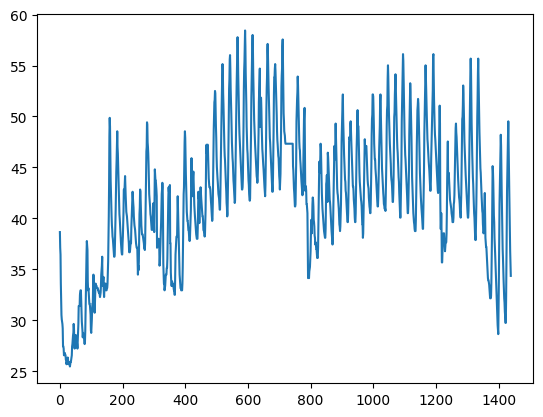

In [4]:
plt.plot(input.squeeze().detach().numpy())

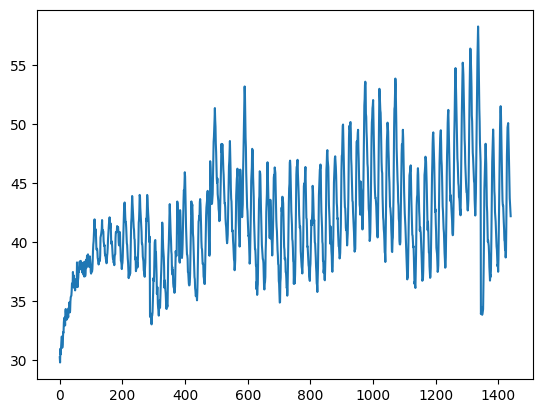

In [5]:
plt.plot(output.squeeze().detach().numpy())

In [10]:
# Note that the output is the whole sequence of next token prediction
# so we need to select the last token (token_len=96) as the final prediction

pred = output[:, -96:, 0].squeeze().detach().numpy()

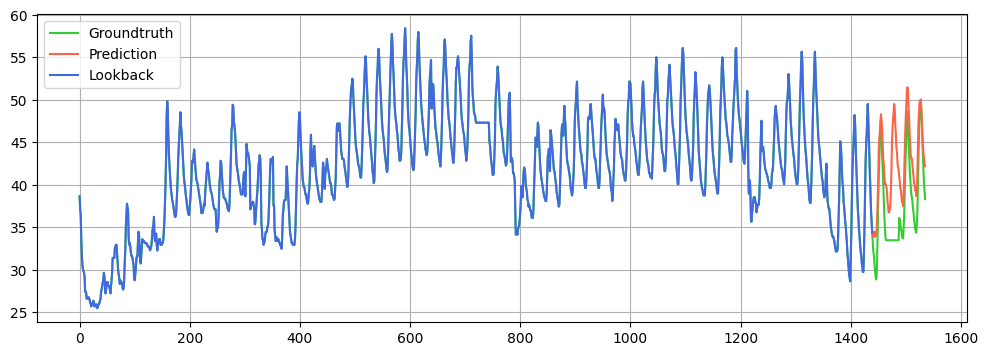

In [11]:
# plot the prediction

plt.figure(figsize=(12, 4))
plt.plot(df["OT"][:lookback_length + prediction_length], color="limegreen", label="Groundtruth")
plt.plot(range(lookback_length, lookback_length + prediction_length), pred, color="tomato", label="Prediction")
plt.plot(df["OT"][:lookback_length], color="royalblue", label="Lookback")
plt.legend()
plt.grid()
plt.show()